In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


def squash(x, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(x), axis, keepdims=True) + 1e-9
    scale = tf.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

input_shape = (32, 32, 3)
num_classes = 10

inputs = layers.Input(shape=input_shape)
conv1 = layers.Conv2D(256, 9, activation='relu')(inputs)
conv2 = layers.Conv2D(256, 9, strides=2, padding='valid')(conv1)

primary_caps = layers.Reshape((-1, 8))(conv2)
primary_caps_squashed = layers.Lambda(squash)(primary_caps)

num_primary_caps = primary_caps_squashed.shape[1]

digit_caps = layers.Dense(num_classes * 16, activation=None)(primary_caps_squashed)
digit_caps_reshaped = layers.Reshape((num_primary_caps, num_classes, 16))(digit_caps)
digit_caps_squashed = layers.Lambda(lambda x: squash(x, axis=-1))(digit_caps_reshaped)

digit_caps_gap = layers.GlobalAveragePooling2D()(digit_caps_squashed)

x = layers.Dense(256, activation='relu')(digit_caps_gap)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=predictions)

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ]
)

test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 256)       62464     
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 256)         5308672   
                                                                 
 reshape_15 (Reshape)        (None, 2048, 8)           0         
                                                                 
 lambda_19 (Lambda)          (None, 2048, 8)           0         
                                                                 
 dense_12 (Dense)            (None, 2048, 160)         1440      
                                                                 
 reshape_16 (Reshape)        (None, 2048, 10, 16)      0   

In [ ]:
new_history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ]
)

Epoch 1/50
625/625 [==============================] - 35s 56ms/step - loss: 1.0282 - accuracy: 0.6300 - val_loss: 1.1547 - val_accuracy: 0.5778 - lr: 2.0000e-04
Epoch 2/50
625/625 [==============================] - 34s 54ms/step - loss: 1.0236 - accuracy: 0.6315 - val_loss: 1.1486 - val_accuracy: 0.5782 - lr: 2.0000e-04
Epoch 3/50
625/625 [==============================] - 34s 54ms/step - loss: 1.0210 - accuracy: 0.6338 - val_loss: 1.1477 - val_accuracy: 0.5798 - lr: 2.0000e-04
Epoch 4/50
625/625 [==============================] - 35s 55ms/step - loss: 1.0171 - accuracy: 0.6353 - val_loss: 1.1454 - val_accuracy: 0.5807 - lr: 2.0000e-04
Epoch 5/50
625/625 [==============================] - 34s 54ms/step - loss: 1.0122 - accuracy: 0.6364 - val_loss: 1.1441 - val_accuracy: 0.5829 - lr: 2.0000e-04
Epoch 6/50
625/625 [==============================] - 34s 55ms/step - loss: 1.0092 - accuracy: 0.6370 - val_loss: 1.1454 - val_accuracy: 0.5808 - lr: 2.0000e-04
Epoch 7/50
625/625 [==============

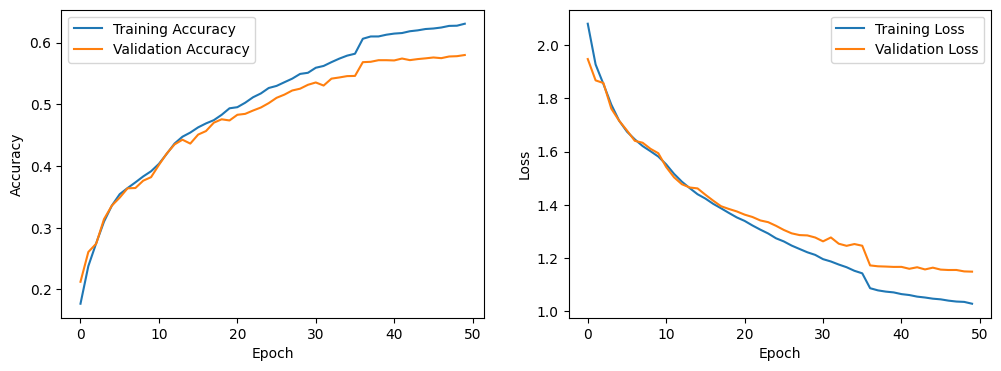

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

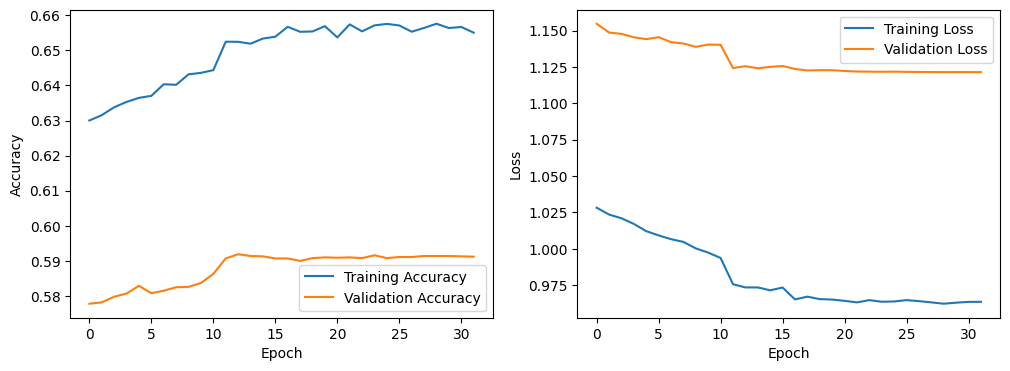

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(new_history.history['accuracy'], label='Training Accuracy')
plt.plot(new_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(new_history.history['loss'], label='Training Loss')
plt.plot(new_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


157/157 [==============================] - 3s 15ms/step
Precision: 0.5939
Recall: 0.5991
F1-score: 0.5957
